<img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0 November 2019  
Copyright &copy; 2003-2019 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='admissions'></a>admissions table
This table contains all admissions and demographic data of the patients admitted to the intensive care unit (ICU, Dutch abbreviation: IC) or medium care unit (MCU, high dependency unit, Dutch abbreviation: MC).

**Note**: reason for admission can be found by examining the Apache II diagnostic categories from the [listitems](listitems.ipynb#apache) table.

## Fields

|Name|Type|Description|
|:---|:---|:---|
|patientid|integer|unique value to identify individual patients throughout their admission(s)|
|admissionid|integer|unique value to identify the admission to the ICU. Patients may have multiple admissionid's during the same or another hospitalization, when they are discharge from the ICU or MC unit. Admissionid is used as an identifier in all other tables.|    
|admissioncount|integer|for each patient, each additional ICU/MCU admission will increase this counter by one|    
|[location](#location)|string|the department the patient has been admitted to, either *IC*, *MC* or both *(IC&MC or MC&IC)*|
|[urgency](#urgency)|bit|determines wheter the admission was urgent (1) (i.e. unplanned) or not (0) (planned)|
|[origin](#origin)|string|department the patient originated from (e.g. Emergency department, regular ward)|
|admittedat|integer|number of milliseconds since the first admission. For the first admission this is set to zero.|
|[admissionyeargroup](#admissionyeargroup)|string|year of admission, categorised|
|dischargedat|integer|time of discharge in number of milliseconds since the first admission|    
|lengthofstay|integer|length of stay of the admission in hours|    
|[destination](#destination)|string|department the patient has been discharged to or 'Overleden' if the patient died during the ICU/MCU admission|
|[gender](#gender)|string|gender, 'Man' for male, 'Vrouw' for female|
|[agegroup](#agegroup)|string|age at admission (years), categorised|    
|dateofdeath|integer|the date on which the patient died calculated as the number of milliseconds since the first admission, if applicable (non-null)|    
|[weightgroup](#weightgroup)|string|weight at admission (kg), categorised|    
|weightsource|string|method used to determine the weight at ICU/MCU admission, either measured ('gemeten'), estimated ('geschat') or asked ('anamnestisch')|    
|[lengthgroup](#lengthgroup)|string|length of the patient (cm), categorised|    
|lengthsource|string|method used to determine the length at ICU/MCU admission, either measured ('gemeten'), estimated ('geschat') or asked ('anamnestisch')|    
|[specialty](#specialty)|string|medical specialty the patient has been admitted for|

# Example Python and SQL scripts

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
#since this is a small table we can load all data for some statistics
sql = """
SELECT * FROM admissions;
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT * FROM admissions;

```

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,lengthgroup,lengthsource,specialty
0,0,0,1,IC,0,None,0,2003-2009,148800000,42,16,Vrouw,80+,NaN,60-69,Anamnestisch,160-169,Anamnestisch,Cardiochirurgie
1,1,1,1,IC,0,None,0,2010-2016,96120000,26,15,Man,60-69,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie
2,2,2,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,84240000,23,15,Man,60-69,NaN,90-99,Anamnestisch,180-189,Anamnestisch,Cardiochirurgie
3,3,3,1,MC,0,None,0,2003-2009,84900000,23,14,Man,50-59,NaN,90-99,None,180-189,Gemeten,Cardiochirurgie
4,4,4,1,IC&MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,180900000,50,19,Man,70-79,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie
5,5,5,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,246420000,69,31,Man,50-59,NaN,60-69,Geschat,160-169,Gemeten,Longziekte
6,6,6,1,IC,1,Verpleegafdeling ander ziekenhuis,0,2010-2016,173460000,48,45,Vrouw,80+,NaN,70-79,Geschat,160-169,Geschat,Neurochirurgie
7,7,7,1,MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,148680000,42,41,Man,70-79,NaN,70-79,Gemeten,170-179,Gemeten,Nefrologie
8,8,8,1,IC,0,None,0,2003-2009,84720000,24,15,Man,50-59,NaN,100-109,Geschat,170-179,Anamnestisch,Cardiochirurgie
9,9,9,1,IC,0,None,0,2003-2009,242040000,67,15,Vrouw,70-79,NaN,70-79,None,159-,None,Cardiochirurgie


In [5]:
df.describe()

,patientid,admissionid,admissioncount,admittedat,dischargedat,lengthofstay,dateofdeath
count,23371.000000,23371.000000,23371.000000,2.337100e+04,2.337100e+04,23371.000000,7.901000e+03
mean,10167.647212,11776.635061,1.199221,4.368134e+09,4.771993e+09,112.193916,6.232189e+10
std,5864.994582,6798.713963,0.679753,2.539504e+10,2.542488e+10,234.243303,8.925135e+10
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,-1.382944e+11
25%,5104.500000,5889.500000,1.000000,0.000000e+00,7.536000e+07,20.000000,1.102080e+09
50%,10166.000000,11778.000000,1.000000,0.000000e+00,1.170600e+08,26.000000,1.592100e+10
75%,15251.500000,17663.500000,1.000000,0.000000e+00,5.848500e+08,90.000000,9.292722e+10
max,20326.000000,23552.000000,22.000000,3.916525e+11,3.916687e+11,5697.000000,4.595904e+11


## <a id='location'></a>Location

``` mysql

SELECT 
    location,
    COUNT(admissionid) AS "Admissions per Location"
FROM admissions
GROUP BY location
ORDER BY "Admissions per Location" DESC

```

[Text(0, 0.5, 'Admissions per Location')]

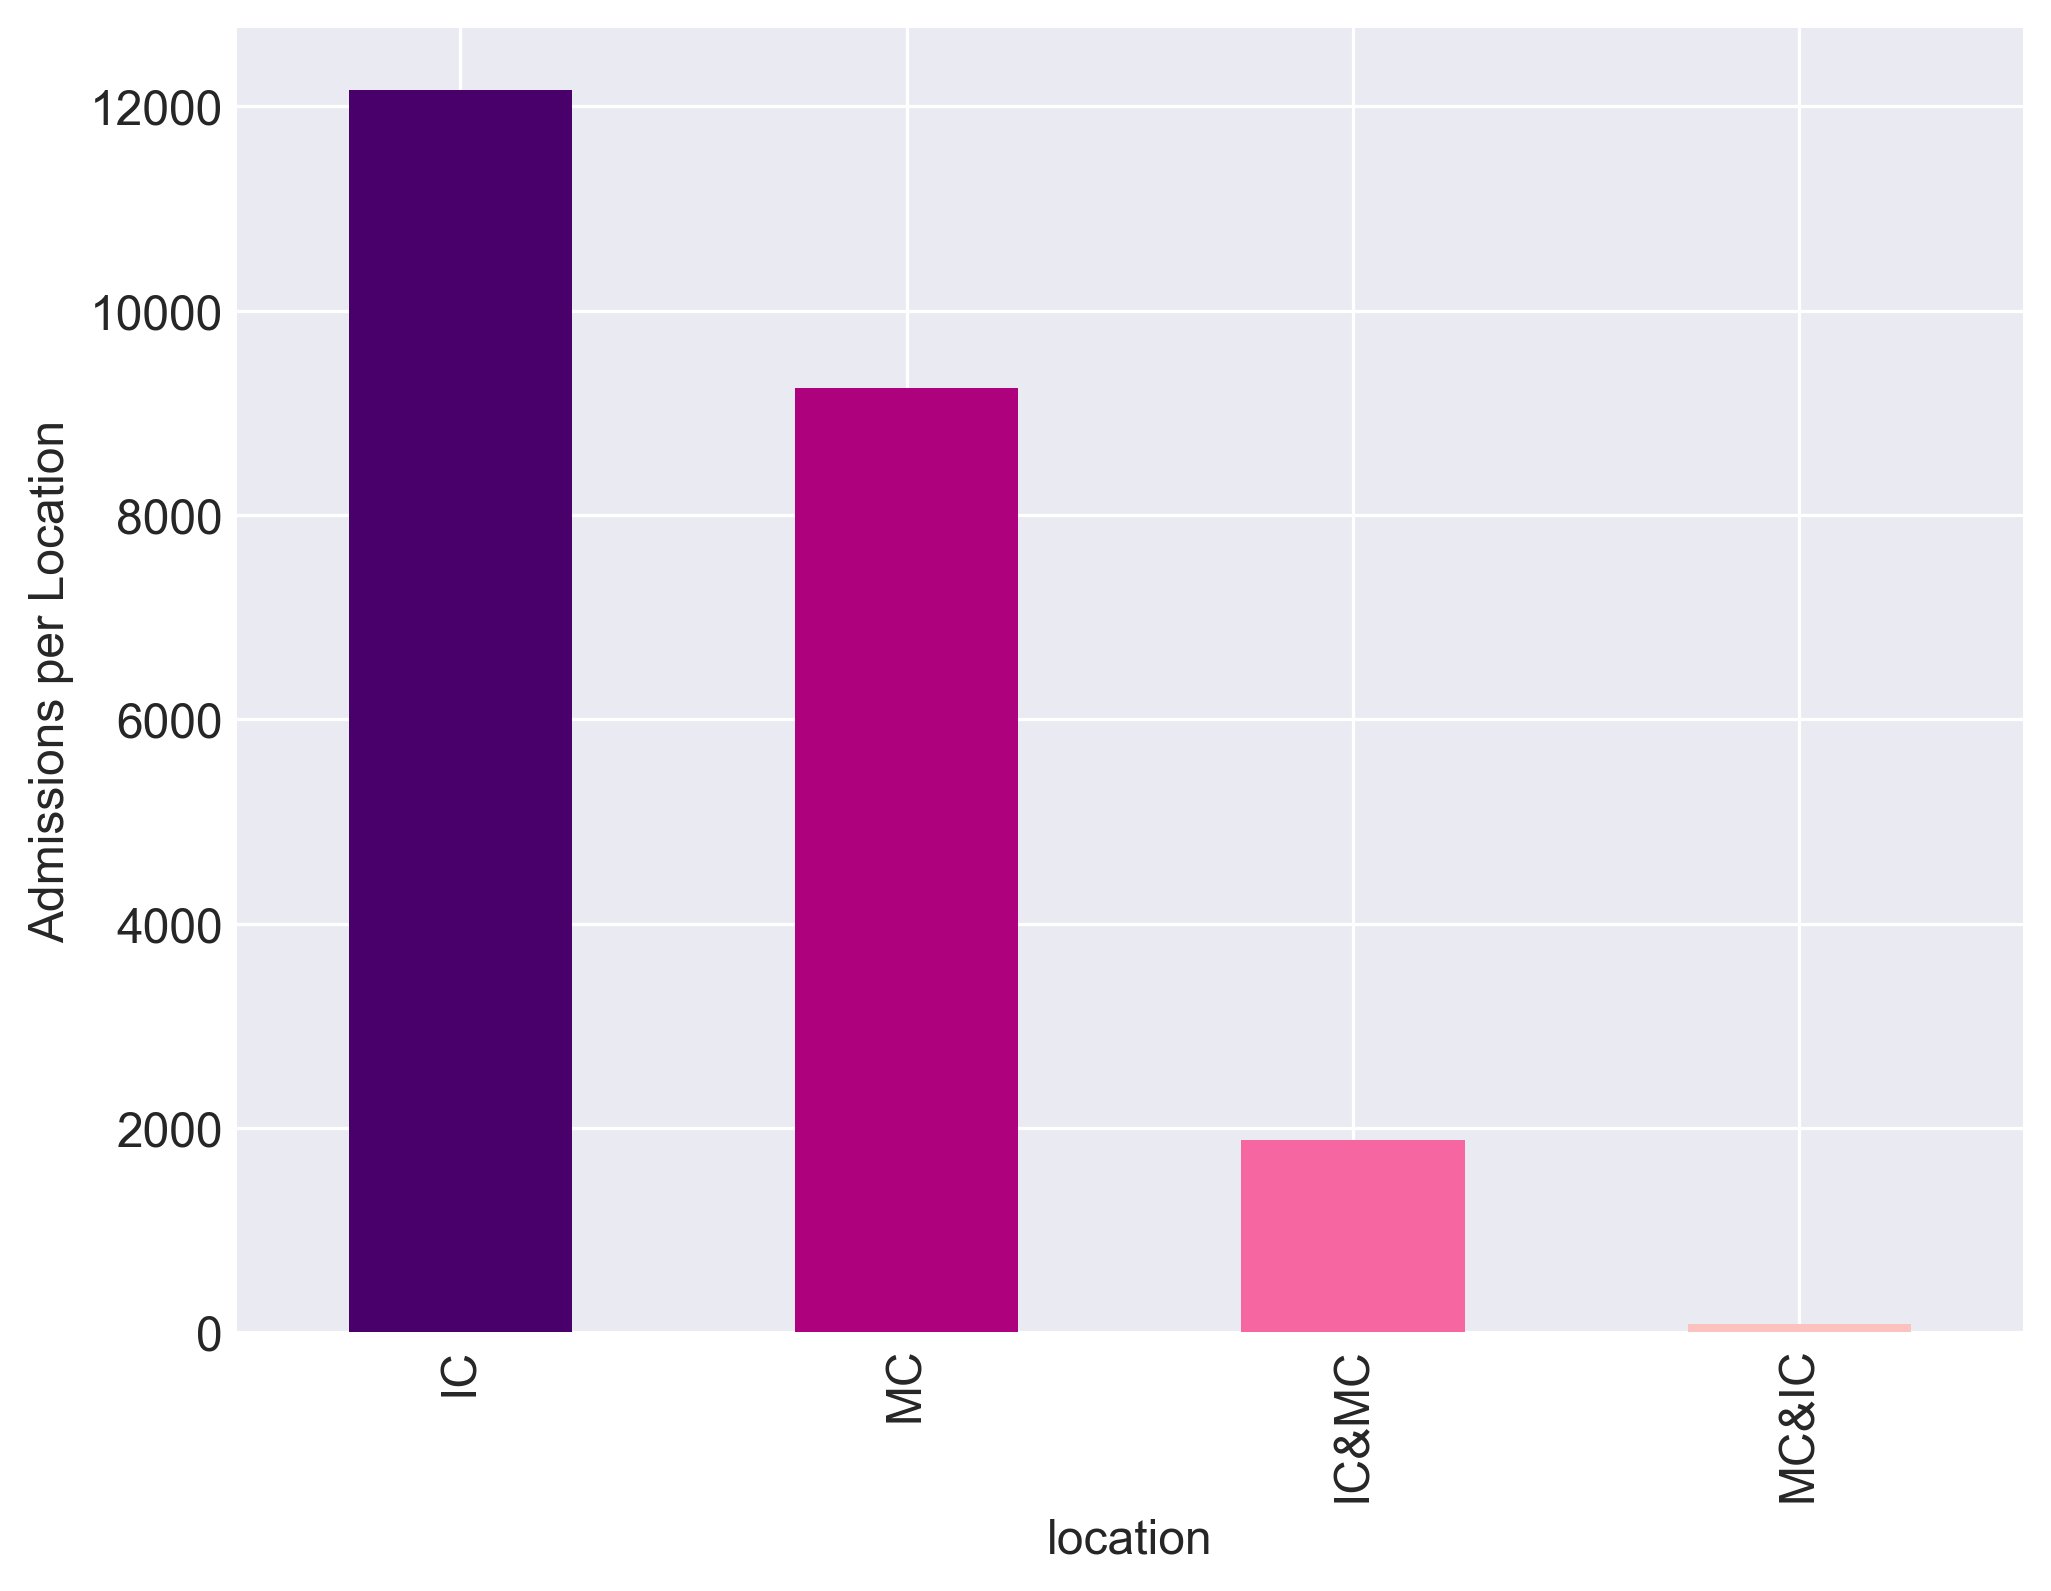

In [6]:
sql = """
SELECT 
    location,
    COUNT(admissionid) AS "Admissions per Location"
FROM admissions
GROUP BY location
ORDER BY "Admissions per Location" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])

## <a id='urgency'></a>Urgency

``` mysql

SELECT 
    CASE 
        WHEN urgency = B'1' THEN 'Unplanned' 
        WHEN urgency = B'0' THEN 'Planned' 
        ELSE 'N/A' 
        END AS "Urgency",
    COUNT(admissionid) AS "Number of Admissions"
FROM admissions
GROUP BY "Urgency"
ORDER BY "Number of Admissions" DESC

```

[Text(0, 0.5, 'Number of Admissions')]

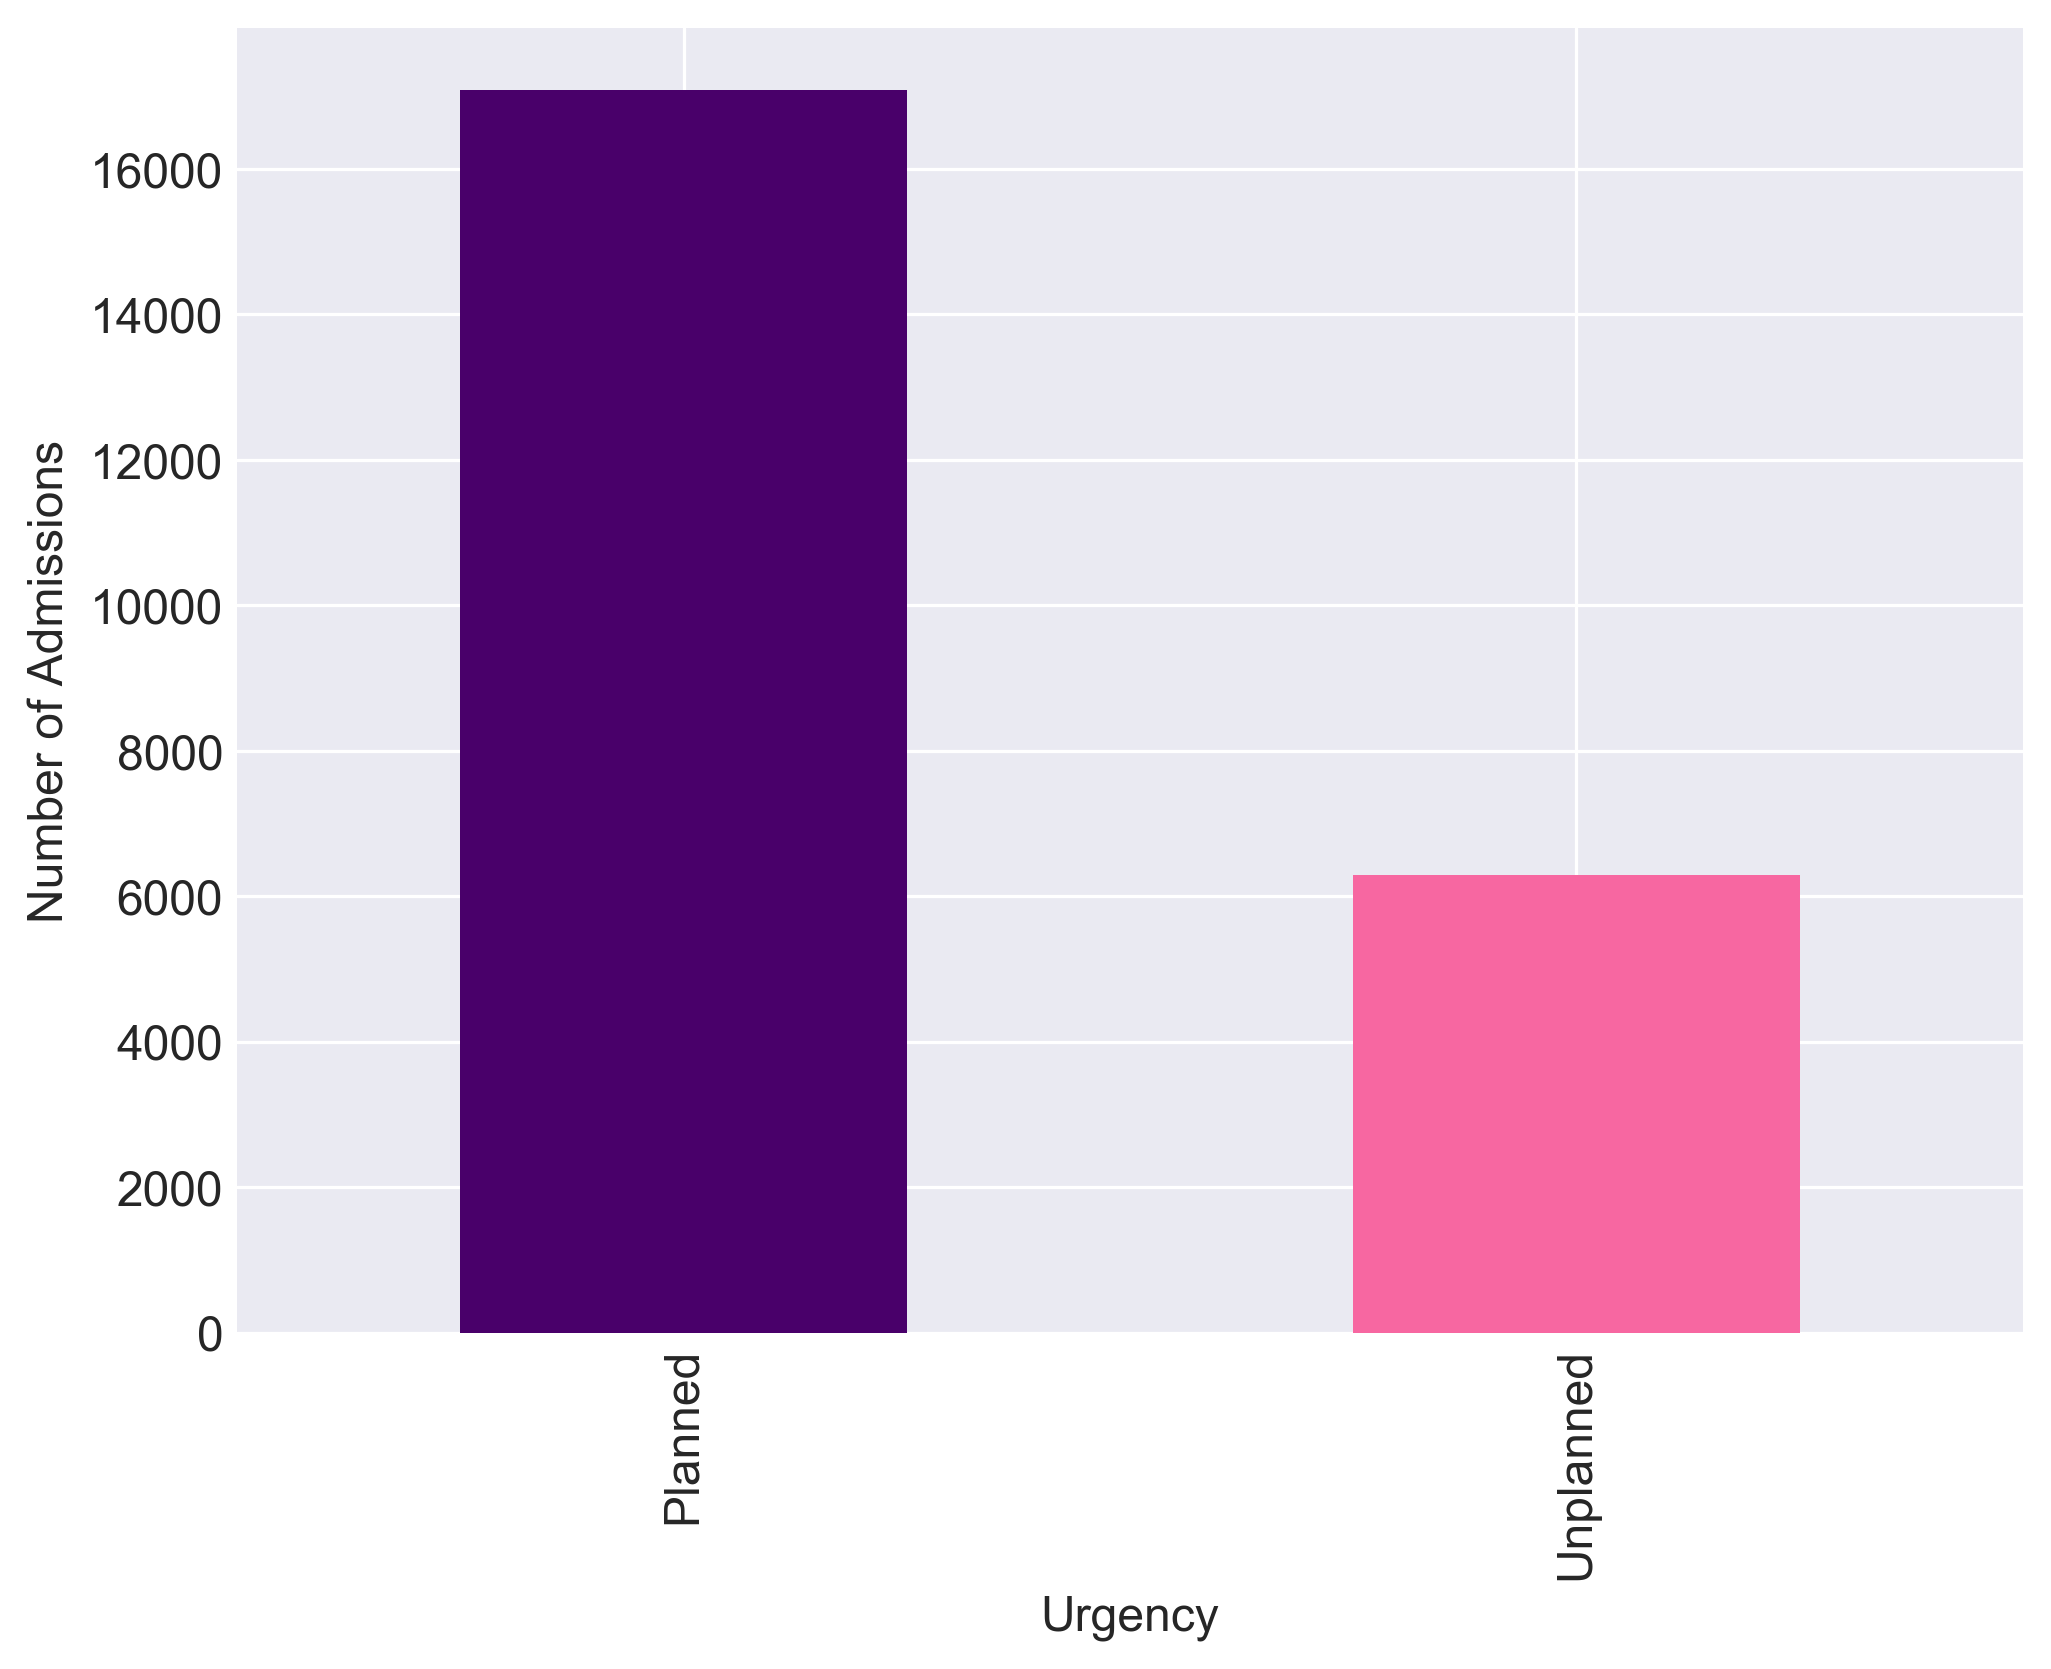

In [7]:
sql = """
SELECT 
    CASE 
        WHEN urgency = B'1' THEN 'Unplanned' 
        WHEN urgency = B'0' THEN 'Planned' 
        ELSE 'N/A' 
        END AS "Urgency",
    COUNT(admissionid) AS "Number of Admissions"
FROM admissions
GROUP BY "Urgency"
ORDER BY "Number of Admissions" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])

## <a id='origin'></a>Origin

``` mysql

SELECT 
    origin as "Origin",
    COUNT(admissionid) as "Number of Admissions"
FROM admissions
GROUP BY origin
ORDER BY "Number of Admissions" DESC

```

[Text(0, 0.5, 'Number of Admissions')]

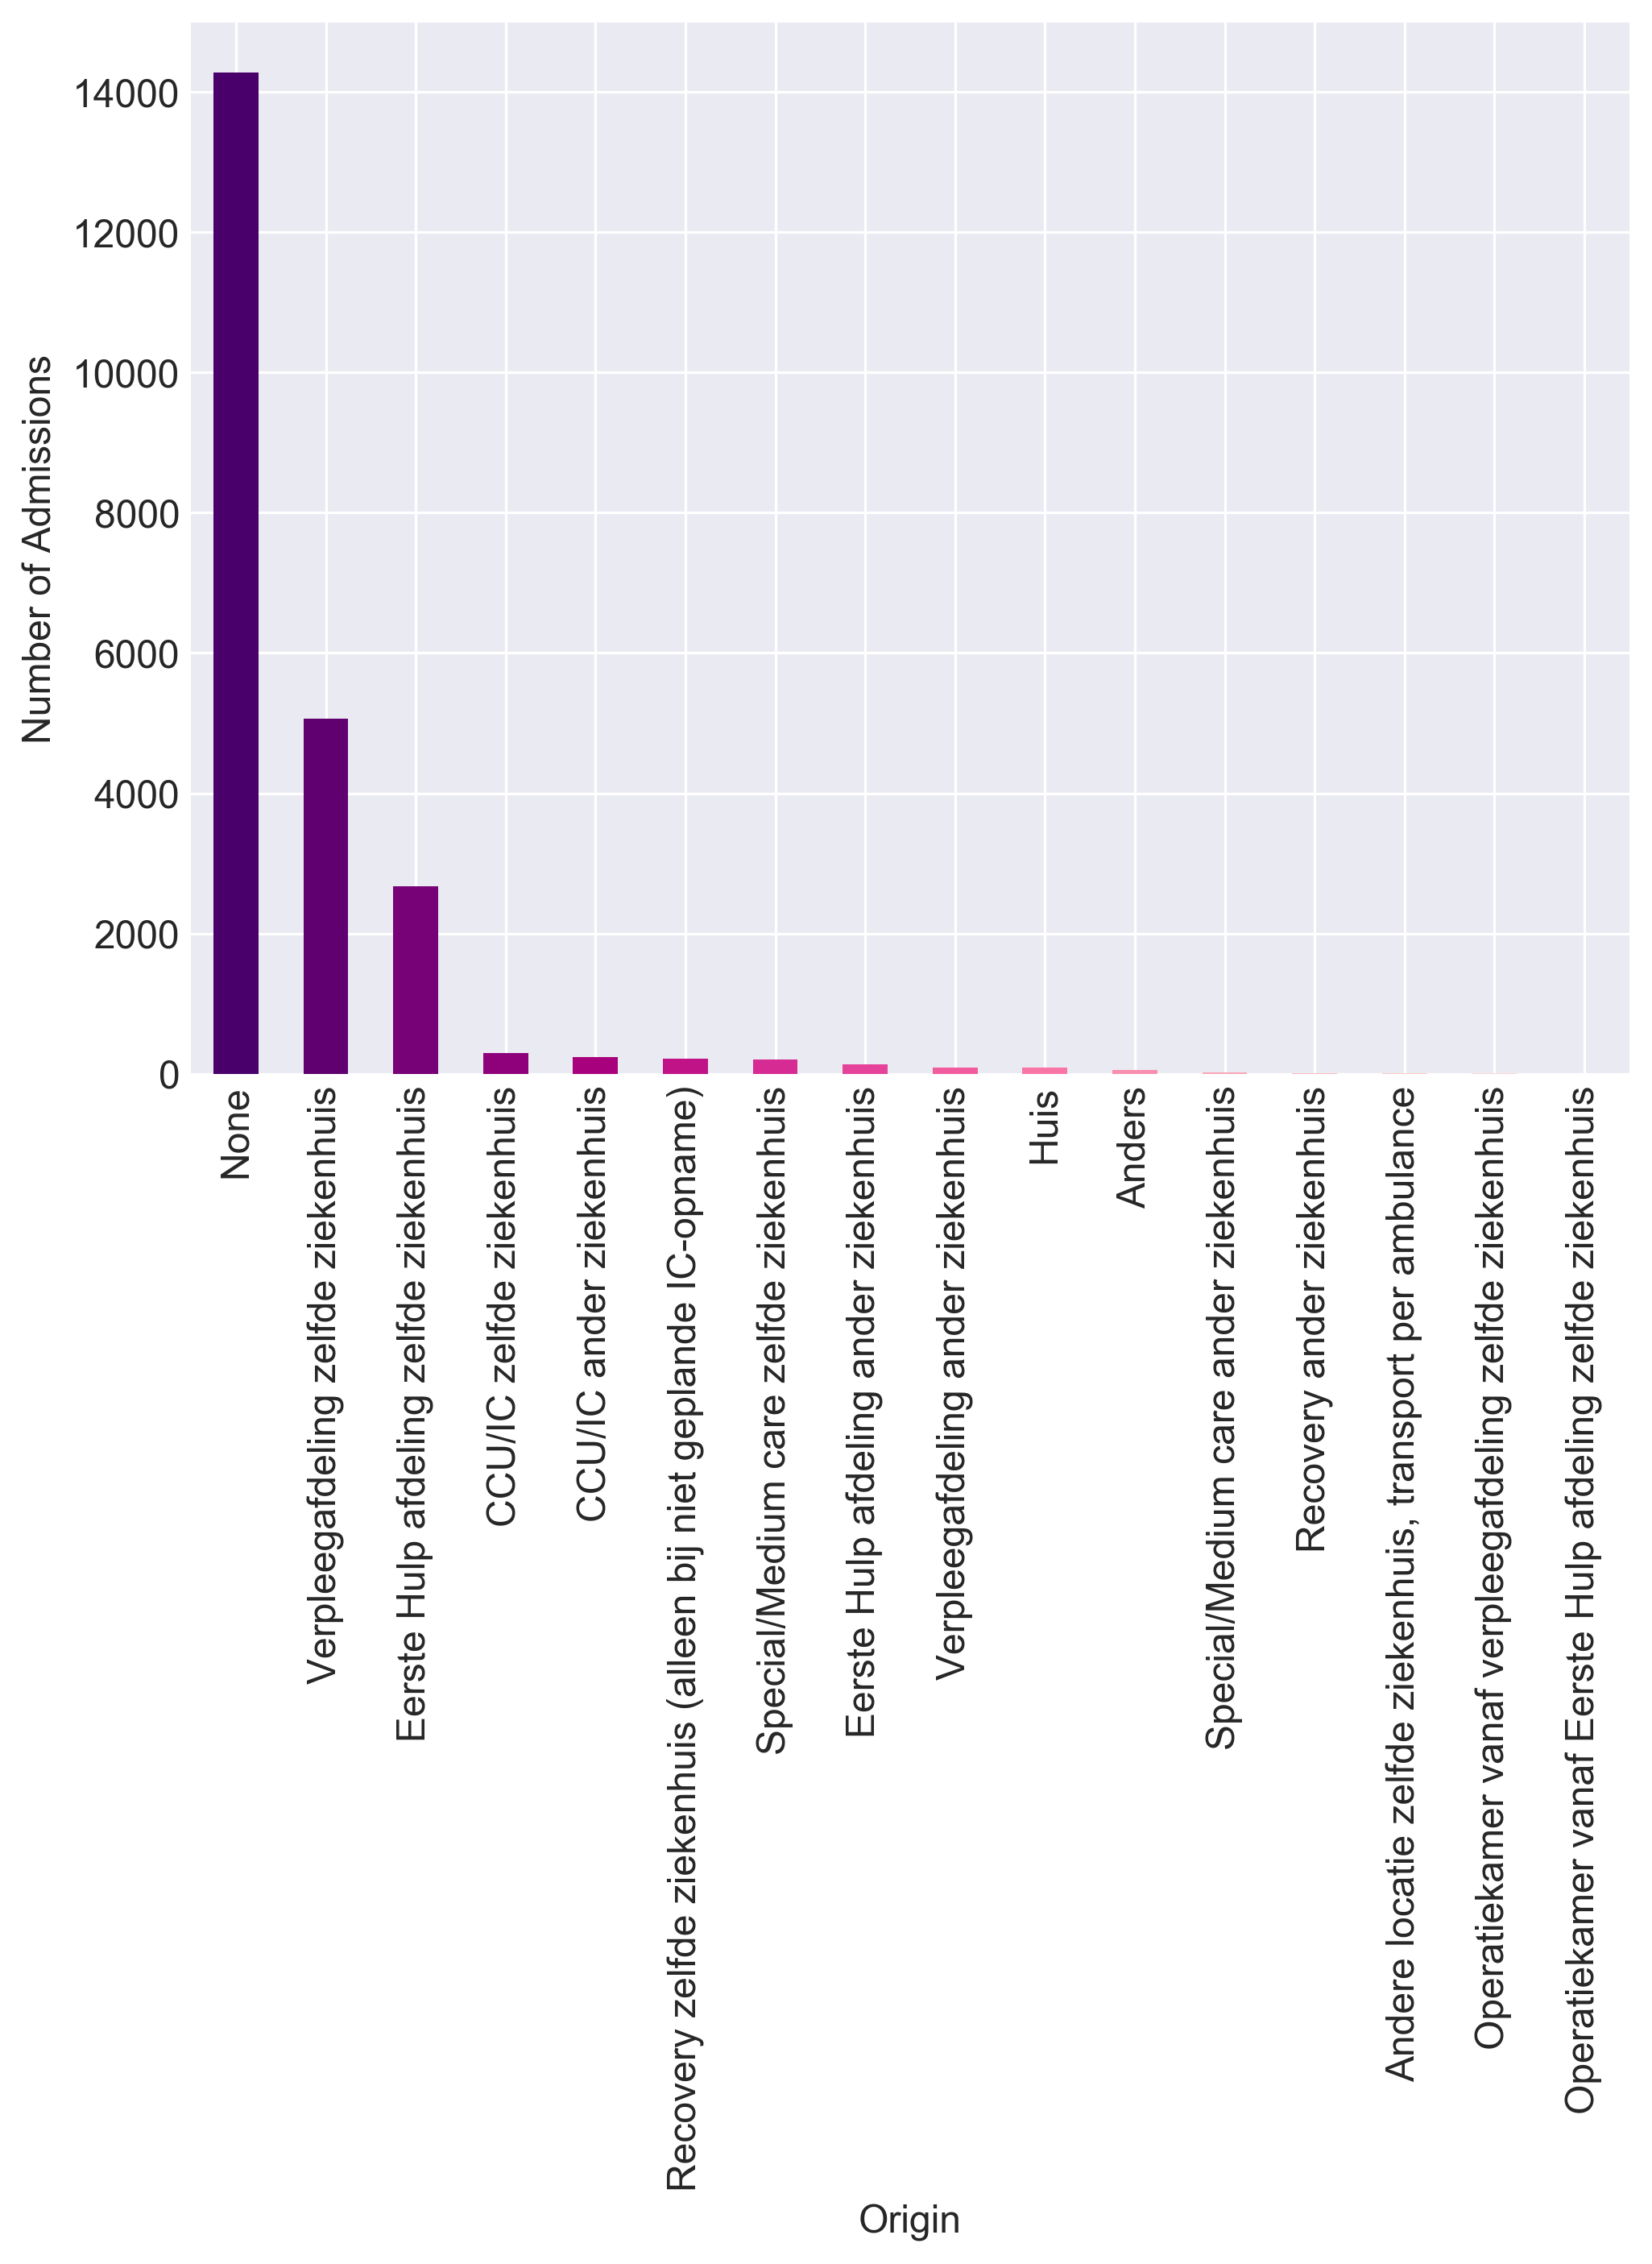

In [8]:
sql = """
SELECT 
    origin as "Origin",
    COUNT(admissionid) as "Number of Admissions"
FROM admissions
GROUP BY origin
ORDER BY "Number of Admissions" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])

## <a id='destination'></a>Destination

In [ ]:
sql = """
SELECT 
    destination as "Destination",
    COUNT(admissionid) as "Number of Admissions"
FROM admissions
GROUP BY destination
ORDER BY "Number of Admissions" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,rot=90,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])

In [10]:
sql = """
SELECT COUNT(DISTINCT patientid) AS "Total Number of Patients", Min(patientid) AS "First ID", Max(patientid) AS "Last ID"
FROM admissions
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(DISTINCT patientid) AS "Total Number of Patients", Min(patientid) AS "First ID", Max(patientid) AS "Last ID"
FROM admissions

```

,Total Number of Patients,First ID,Last ID
0,20169,0,20326


In [ ]:
sql = """
SELECT DISTINCT destination
FROM admissions
ORDER BY destination
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

In [12]:
sql = """
--total number of ICU admissions
SELECT COUNT(DISTINCT admissionid) AS "Total number of admissions"
FROM admissions
    """
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df


``` mysql

--total number of ICU admissions
SELECT COUNT(DISTINCT admissionid) AS "Total number of admissions"
FROM admissions
    
```

,Total number of admissions
0,23371


In [ ]:
sql = """
--patients that expired on the ICU
SELECT COUNT(admissionid) AS "Number of deaths during ICU admission"
FROM admissions
WHERE destination = 'Overleden'
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

In [ ]:
sql = """
SELECT admissionid
  FROM admissions
  WHERE location = 'IC' or location = 'IC&MC'
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

## <a id='admissionyeargroup'></a>Admission year group

``` mysql

SELECT admissionyeargroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY admissionyeargroup
ORDER BY admissionyeargroup ASC

```

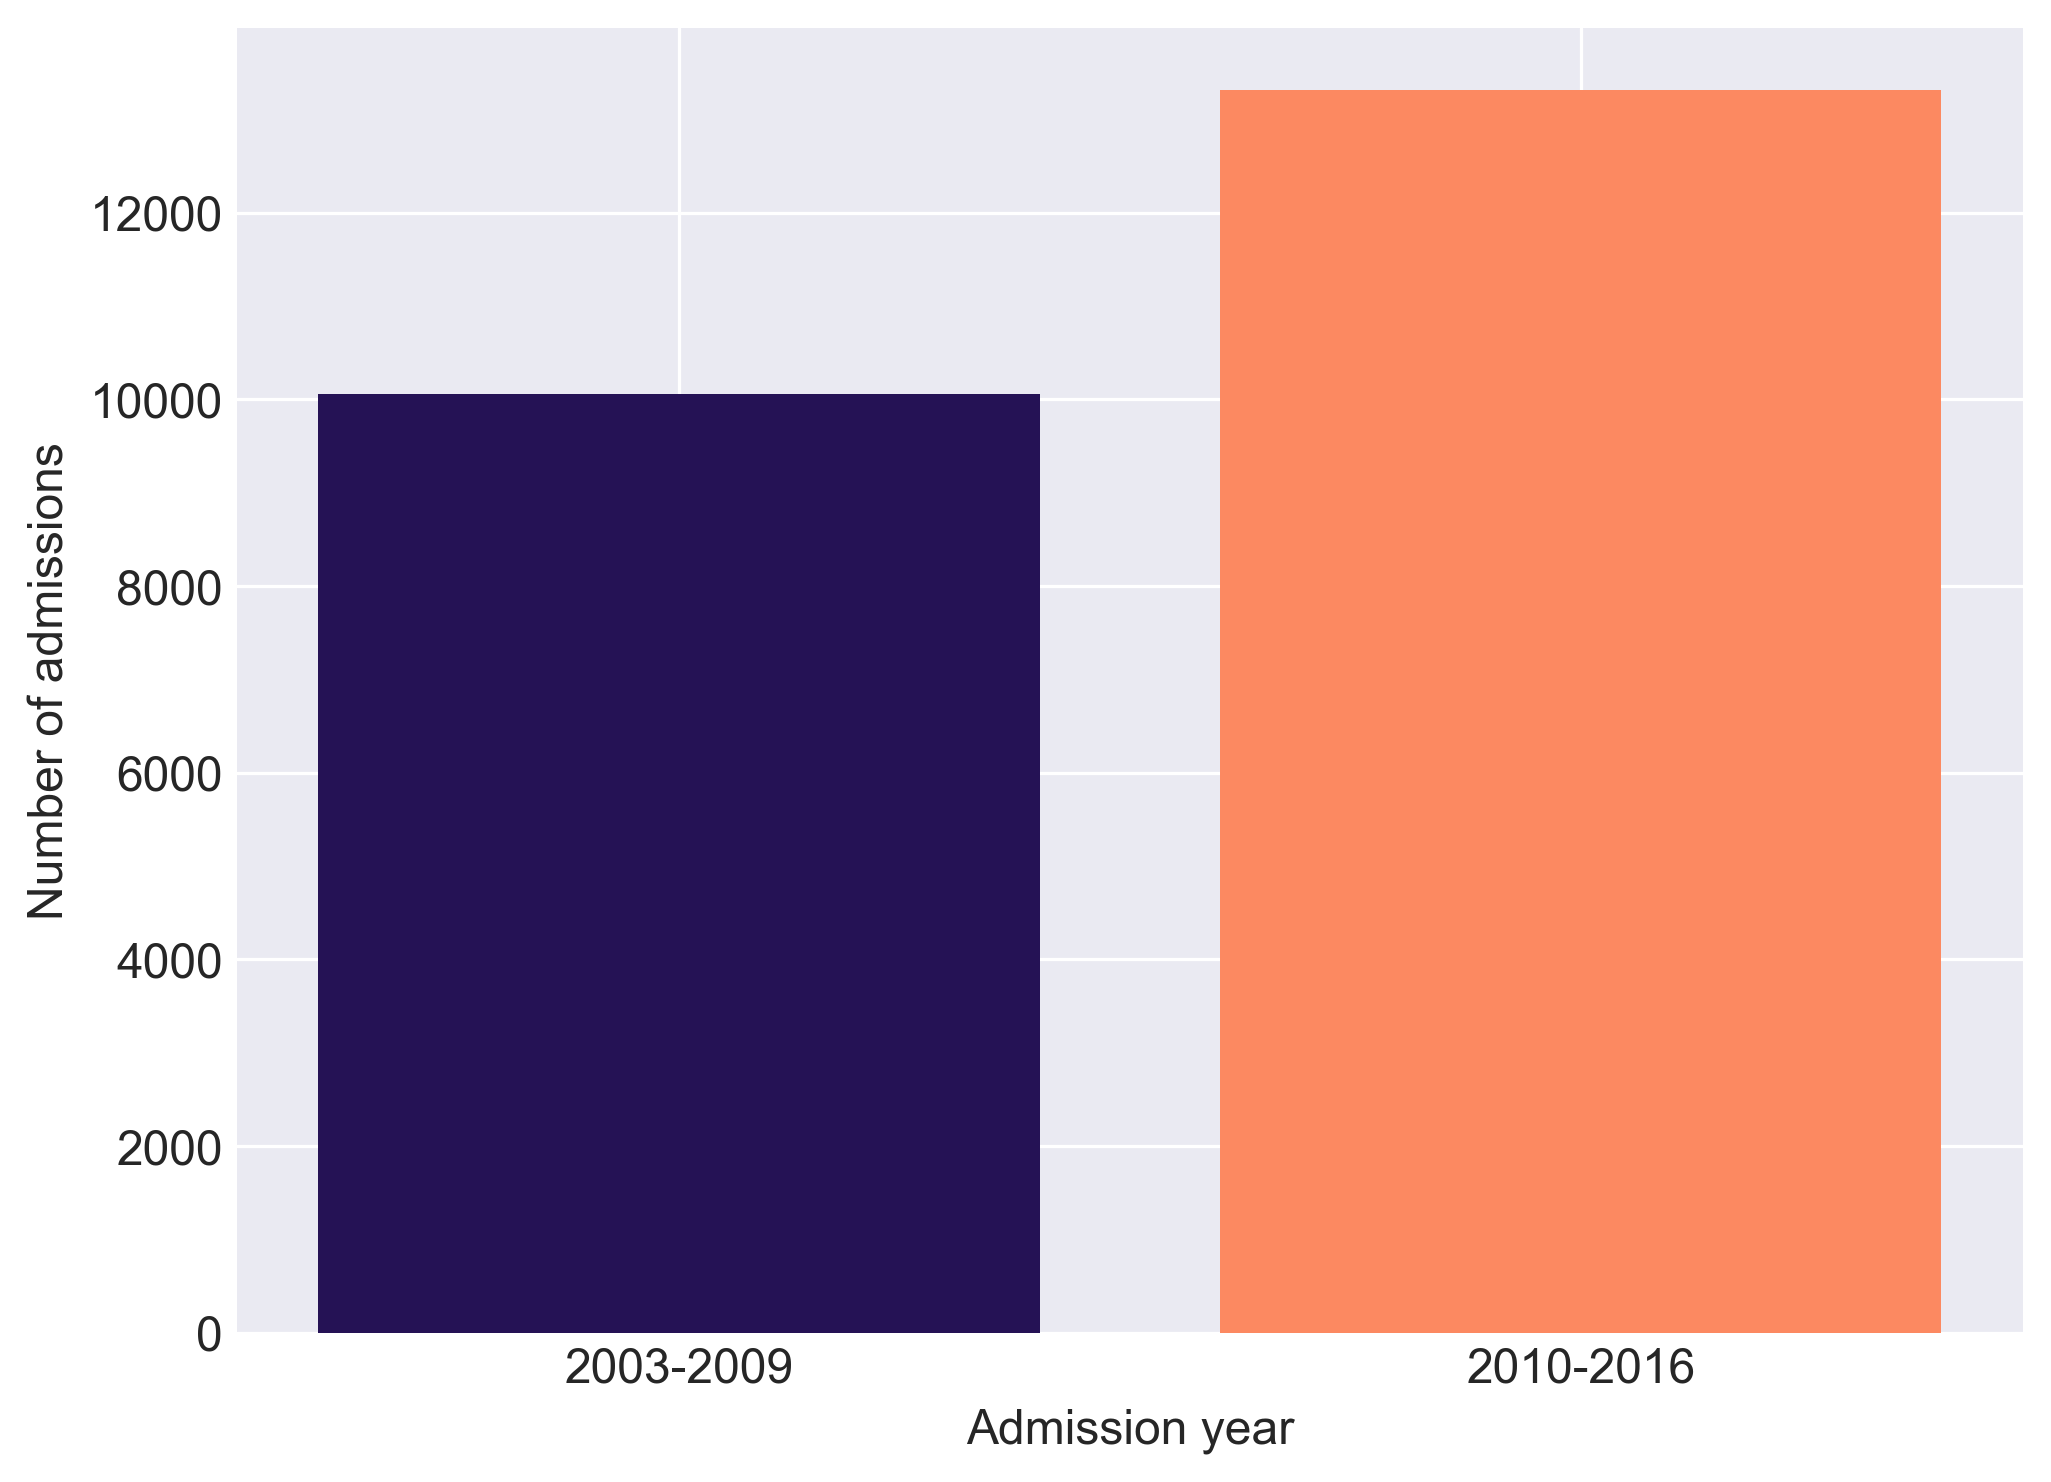

In [15]:
sql = """
SELECT admissionyeargroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY admissionyeargroup
ORDER BY admissionyeargroup ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)

labels = df.iloc[:,0]
x = np.arange(len(labels))
y = df.iloc[:,1]

fig, ax = plt.subplots()
bars = ax.bar(x,y)
patches = bars.patches

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set(ylabel=df.columns[1])
ax.set(xlabel='Admission year')

cm = plt.cm.get_cmap('magma')

#To normalize values
col = (y-y.min())/(y.max()-y.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(0.15+0.6*c))

## <a id='gender'></a>Gender

In [16]:
sql = """
SELECT 
    CASE
        WHEN Gender = 'Man' THEN 'Male'
        WHEN Gender = 'Vrouw' THEN 'Female'
        ELSE 'N/A'
    END AS Gender
    , COUNT(*) AS "Number of patients" -- COUNT(*) counts everything including NULL
FROM admissions
WHERE AdmissionCOUNT = 1
GROUP BY Gender
ORDER BY "Number of patients" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT 
    CASE
        WHEN Gender = 'Man' THEN 'Male'
        WHEN Gender = 'Vrouw' THEN 'Female'
        ELSE 'N/A'
    END AS Gender
    , COUNT(*) AS "Number of patients" -- COUNT(*) counts everything including NULL
FROM admissions
WHERE AdmissionCOUNT = 1
GROUP BY Gender
ORDER BY "Number of patients" DESC

```

,gender,Number of patients
0,Male,12827
1,Female,6868
2,N/A,474


``` mysql

SELECT 
    CASE
        WHEN Gender = 'Man' THEN 'Male'
        WHEN Gender = 'Vrouw' THEN 'Female'
        ELSE 'N/A'
    END AS Gender
    , COUNT(*) AS "Number of patients" -- COUNT(*) counts everything including NULL
FROM admissions
WHERE AdmissionCOUNT = 1
GROUP BY Gender
ORDER BY "Number of patients" DESC

```

[Text(0, 0.5, 'Number of patients')]

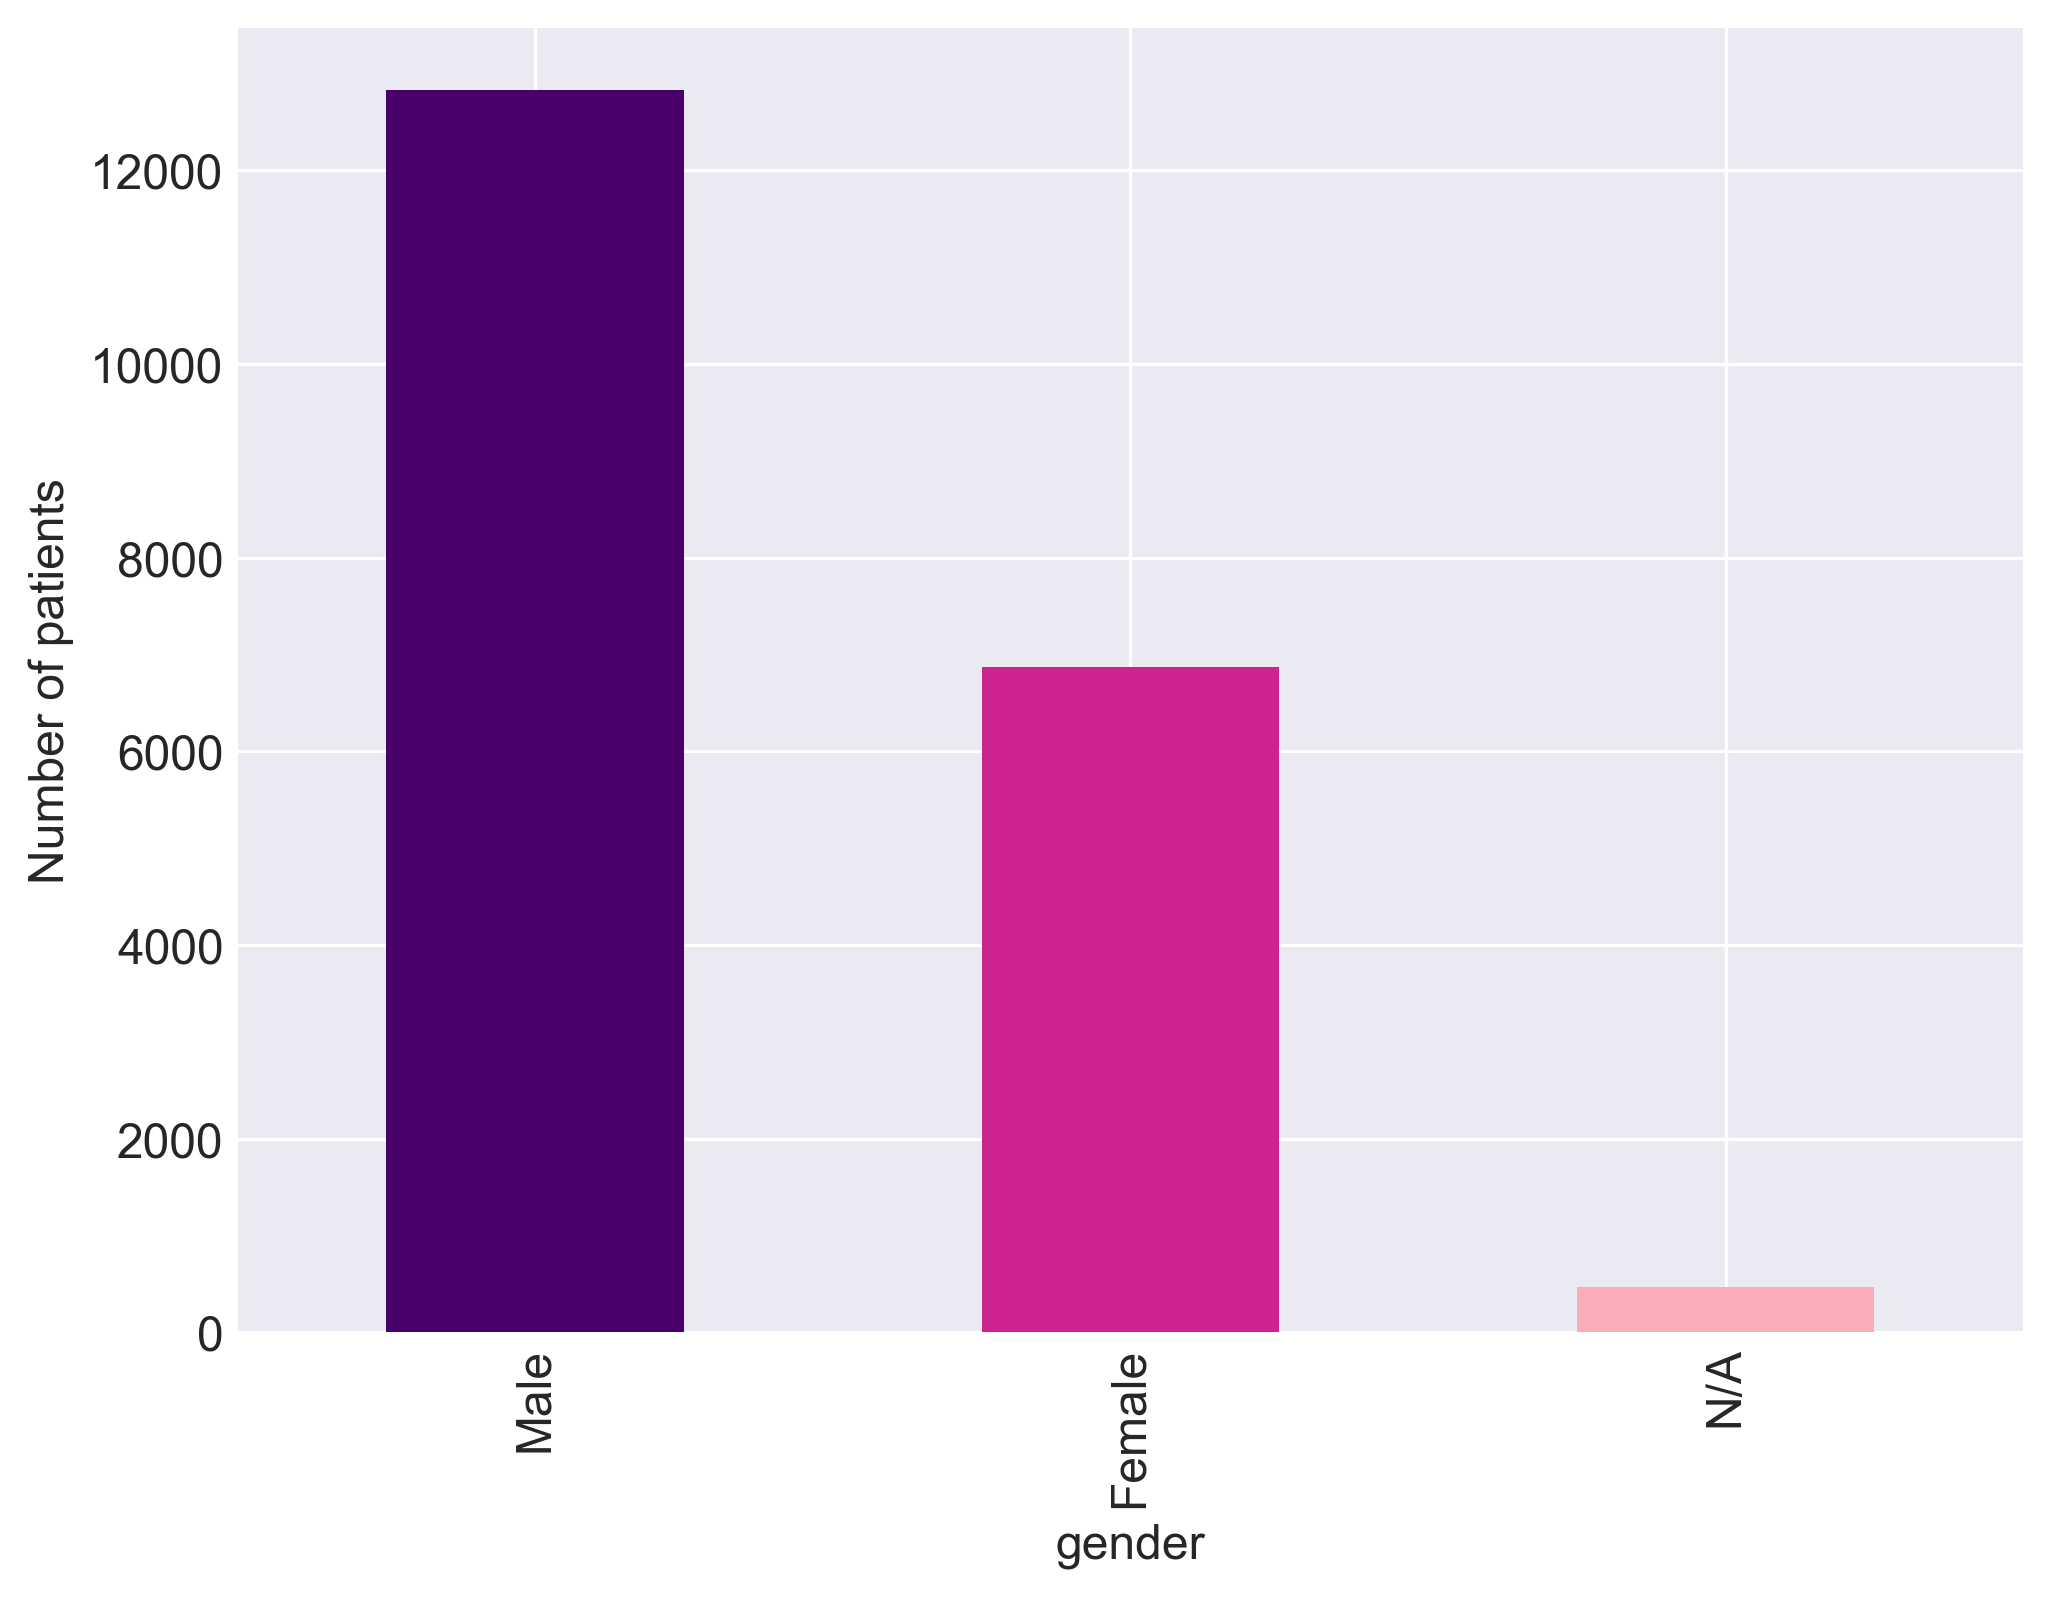

In [17]:
sql = """
SELECT 
    CASE
        WHEN Gender = 'Man' THEN 'Male'
        WHEN Gender = 'Vrouw' THEN 'Female'
        ELSE 'N/A'
    END AS Gender
    , COUNT(*) AS "Number of patients" -- COUNT(*) counts everything including NULL
FROM admissions
WHERE AdmissionCOUNT = 1
GROUP BY Gender
ORDER BY "Number of patients" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])

## <a id='agegroup'></a>Age Groups

In [18]:
sql = """
SELECT agegroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY agegroup
ORDER BY agegroup ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT agegroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY agegroup
ORDER BY agegroup ASC

```

,agegroup,Number of admissions
0,18-39,2581
1,40-49,2229
2,50-59,4016
3,60-69,6134
4,70-79,6122
5,80+,2289


``` mysql

SELECT agegroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY agegroup
ORDER BY agegroup ASC

```

[Text(0.5, 0, 'Age')]

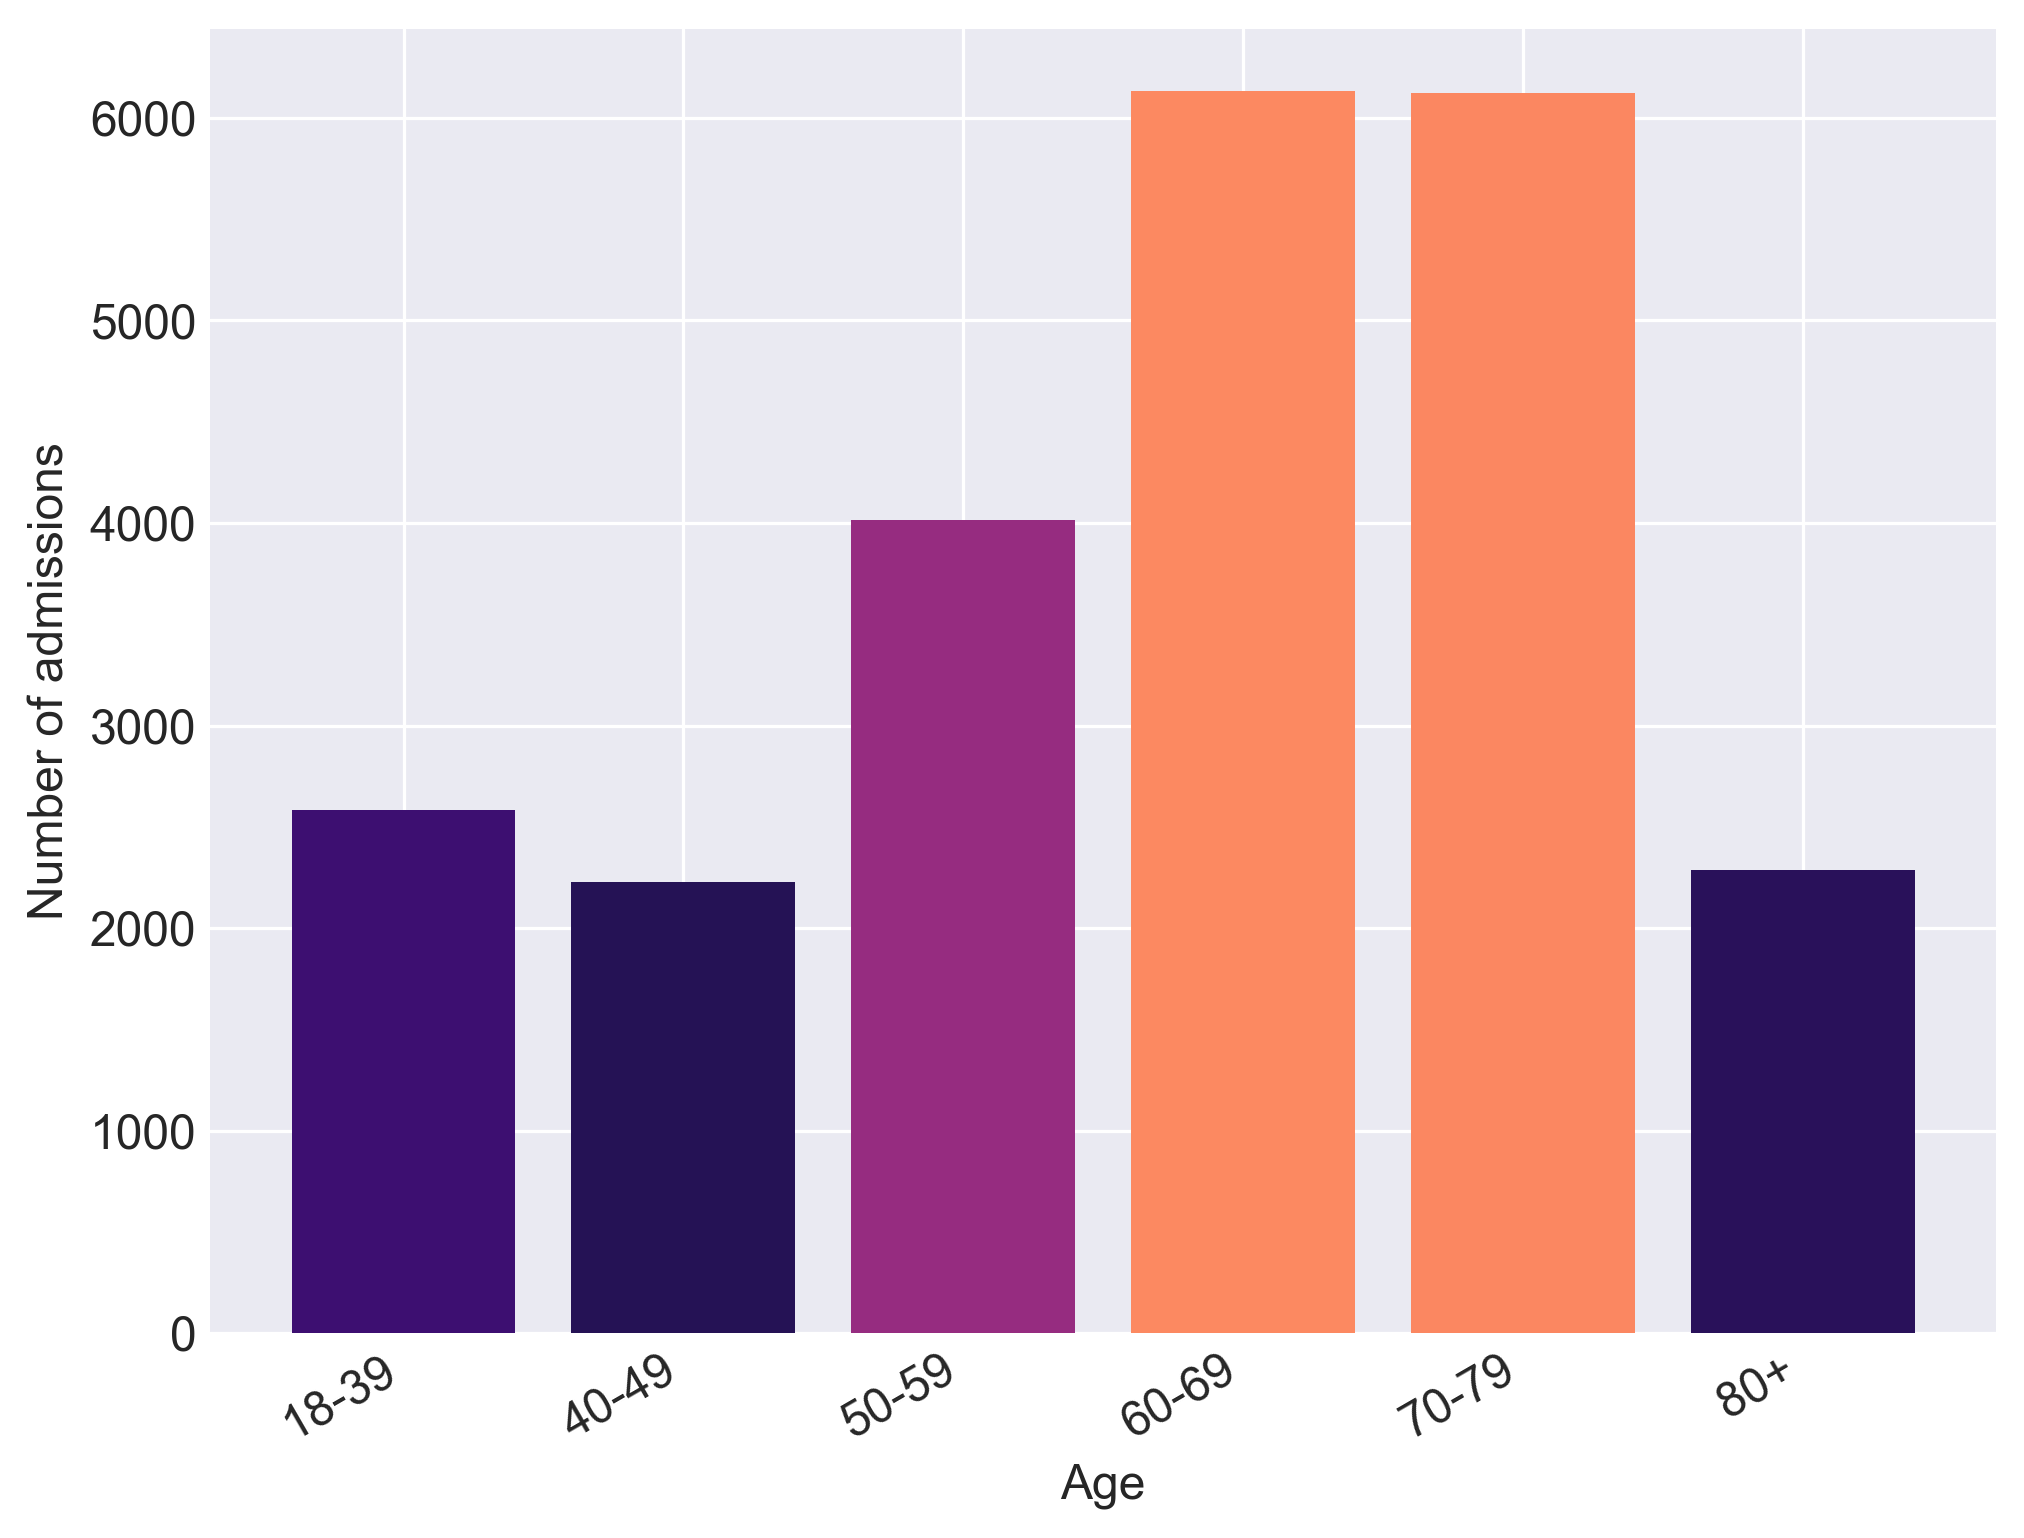

In [19]:
sql = """
SELECT agegroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY agegroup
ORDER BY agegroup ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)

labels = df.iloc[:,0]
x = np.arange(len(labels))
y = df.iloc[:,1]

fig, ax = plt.subplots()
bars = ax.bar(x,y)
patches = bars.patches

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, horizontalalignment='right')

cm = plt.cm.get_cmap('magma')

#To normalize your values
col = (y-y.min())/(y.max()-y.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(0.15+0.6*c))
    
ax.set(ylabel=df.columns[1])
ax.set(xlabel='Age')

In [ ]:
sql = """
SELECT agegroup
    ,CASE
        WHEN destination = 'Overleden' THEN 1
        ELSE 0
    END AS died
FROM admissions
ORDER BY agegroup ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)

alive = df[df['died'] == 0].groupby(['agegroup']).count()
died = df[df['died'] == 1].groupby(['agegroup']).count()

labels = alive.index
x = np.arange(len(labels))

fig, ax = plt.subplots()
bars1 = ax.bar(x,alive.iloc[:,0]/np.sum(alive.iloc[:,0]), width=1.0, facecolor='g', alpha=0.40, label='Alive at discharge')
bars2 = ax.bar(x,died.iloc[:,0]/np.sum(died.iloc[:,0]), width=1.0, facecolor='r', alpha=0.60, label='Died')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Proportion')
ax.set_xlabel('Age group')
ax.set_title('Age distribution of Alive vs death at ICU discharge')

## <a id='Weightgroup'></a>weightgroup

``` mysql

SELECT 
    CASE WHEN weightgroup IS NULL THEN 'N/A'
    ELSE weightgroup
    END as weightgroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY weightgroup
ORDER BY CAST (SUBSTRING ( weightgroup FROM  '^[0-9]+' ) AS INTEGER) ASC

```

[Text(0.5, 0, 'Weight')]

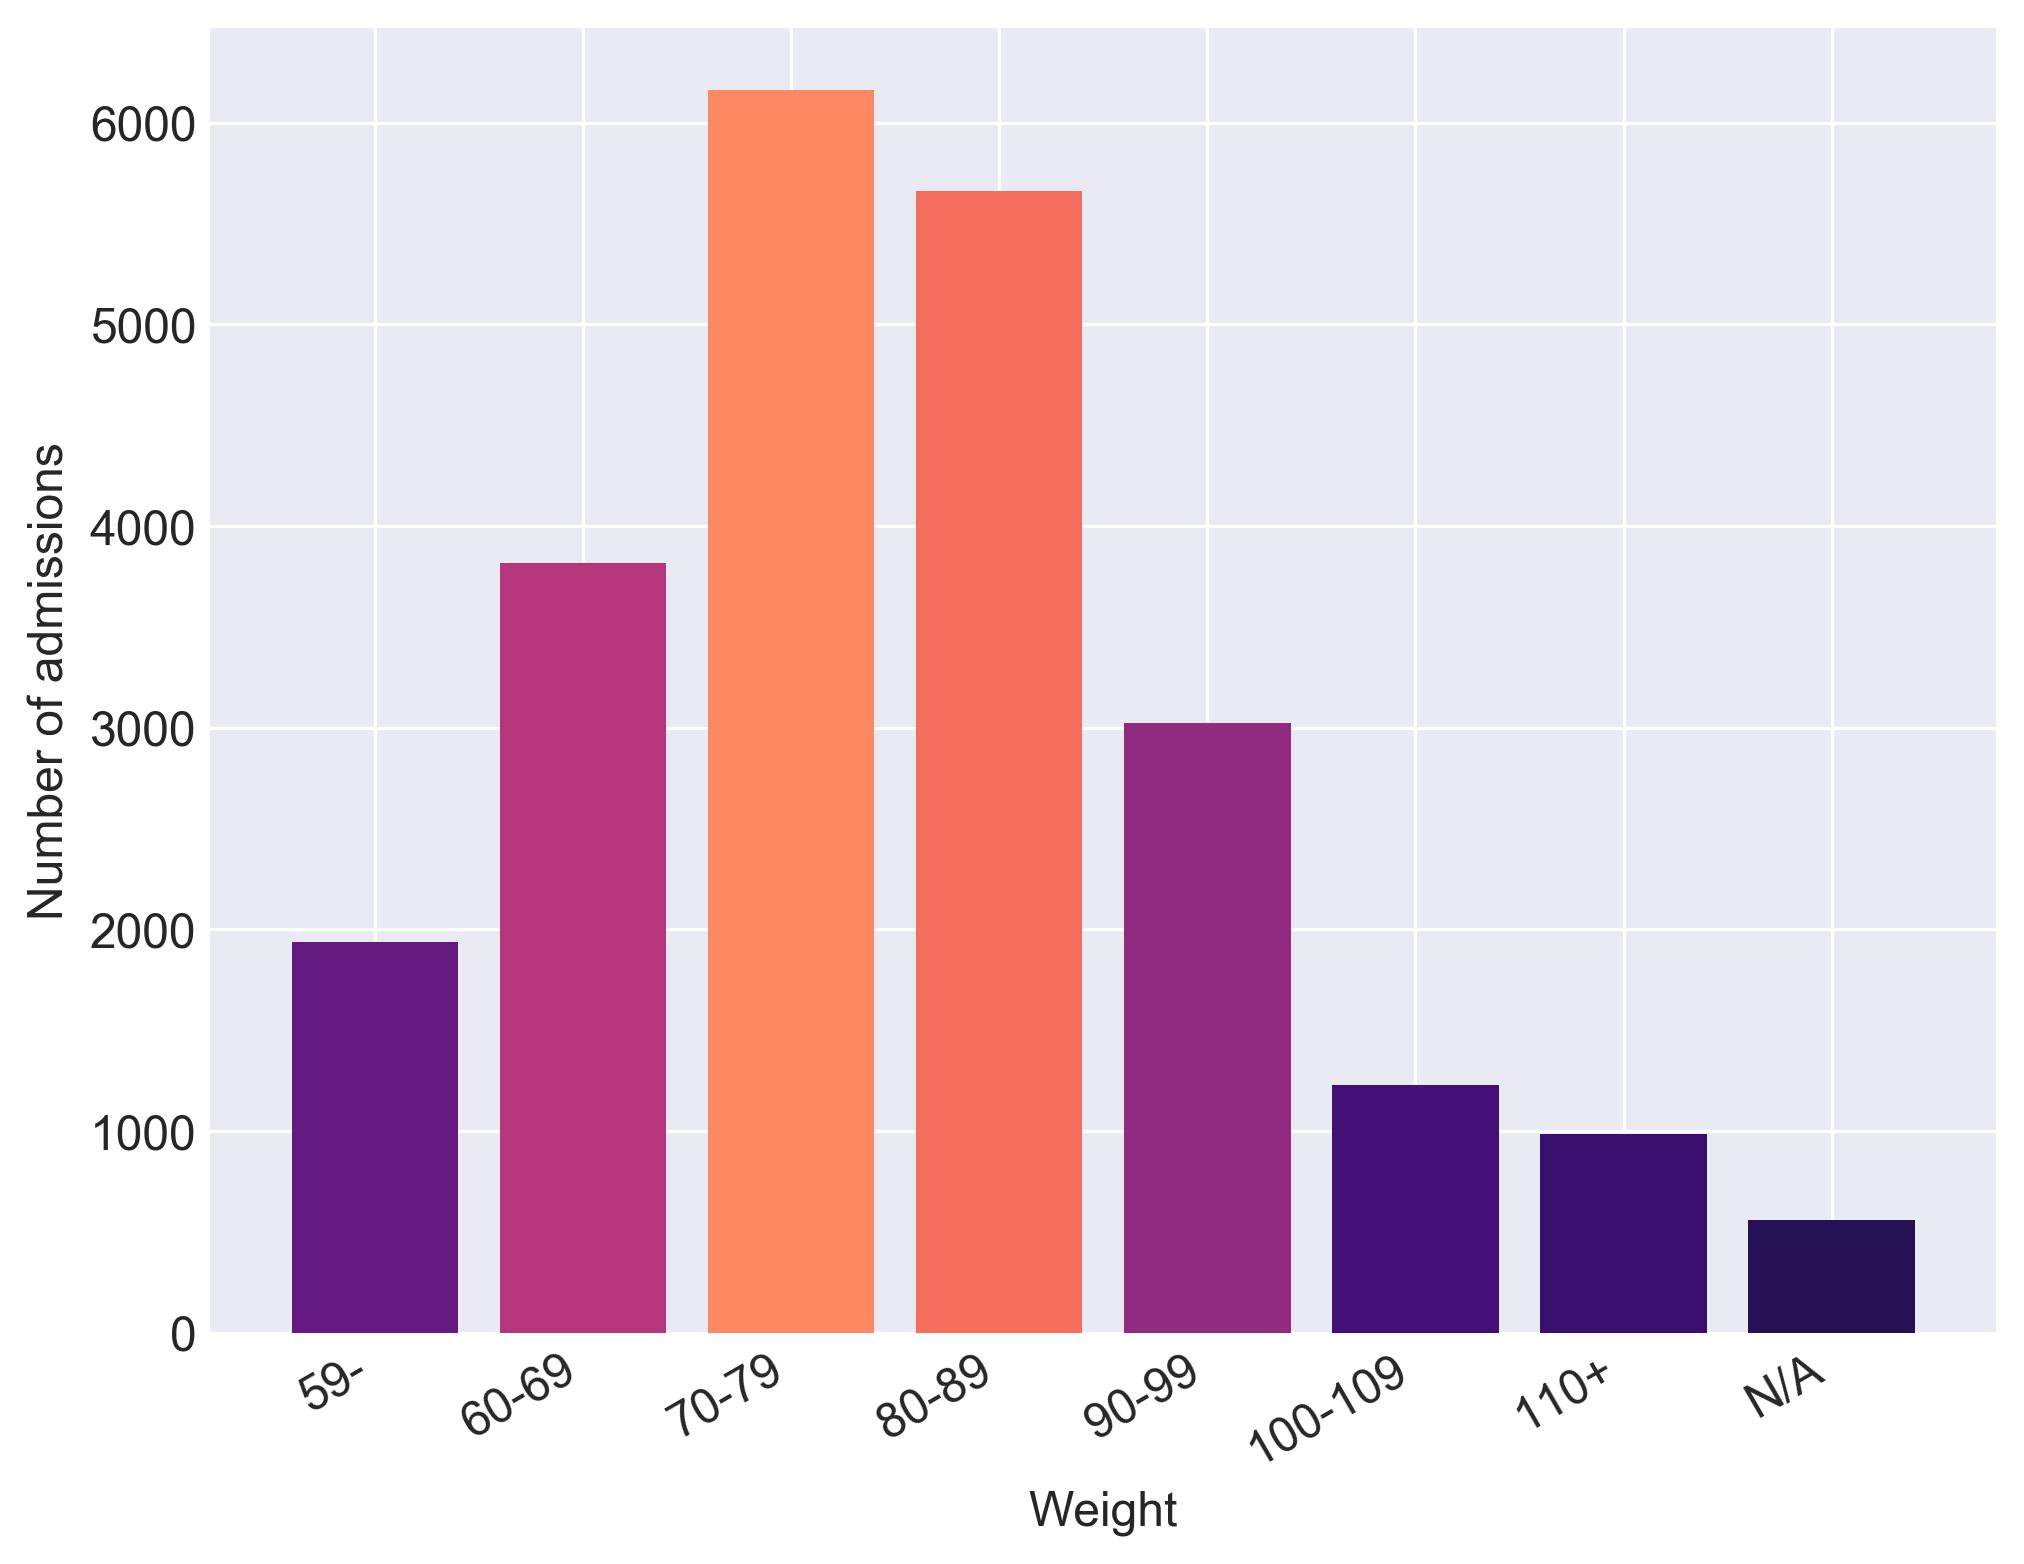

In [21]:
sql = """
SELECT 
    CASE WHEN weightgroup IS NULL THEN 'N/A'
    ELSE weightgroup
    END as weightgroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY weightgroup
ORDER BY CAST (SUBSTRING ( weightgroup FROM  '^[0-9]+' ) AS INTEGER) ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)

labels = df.iloc[:,0]
x = np.arange(len(labels))
y = df.iloc[:,1]

fig, ax = plt.subplots()
bars = ax.bar(x,y)
patches = bars.patches

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, horizontalalignment='right')

cm = plt.cm.get_cmap('magma')

#To normalize your values
col = (y-y.min())/(y.max()-y.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(0.15+0.6*c))
    
ax.set(ylabel=df.columns[1])
ax.set(xlabel='Weight')

## <a id='lengthgroup'></a>lengthgroup

``` mysql

SELECT 
    CASE WHEN lengthgroup IS NULL THEN 'N/A'
    ELSE lengthgroup
    END as lengthgroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY lengthgroup
ORDER BY CAST (SUBSTRING ( lengthgroup FROM  '^[0-9]+' ) AS INTEGER) ASC

```

[Text(0.5, 0, 'Length')]

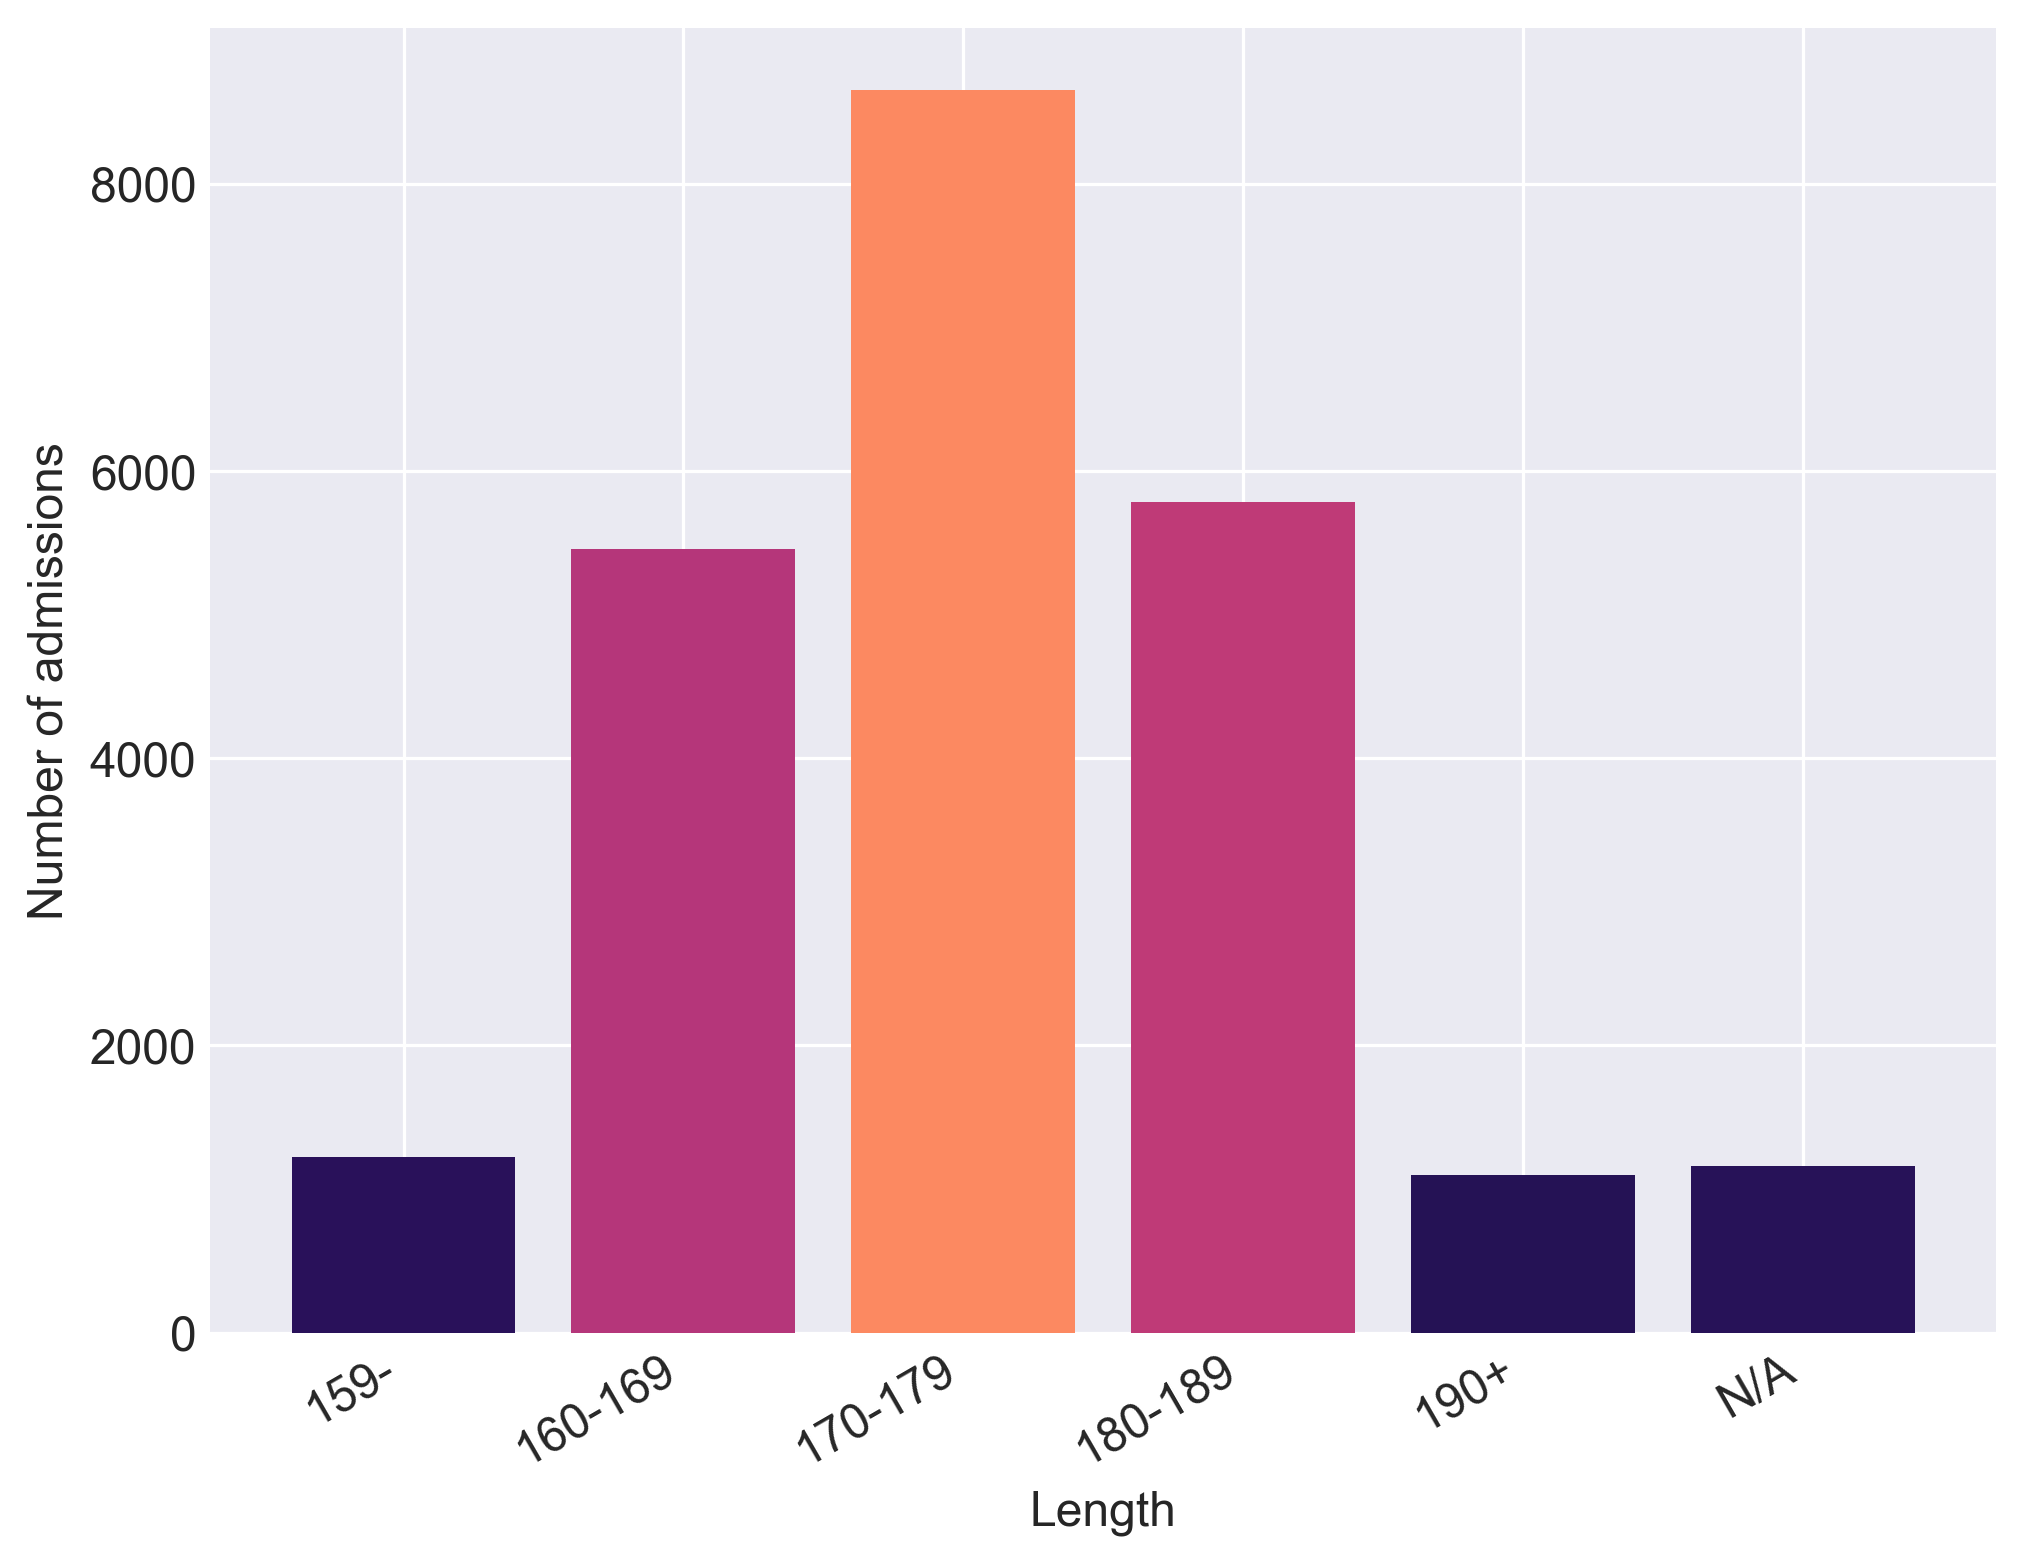

In [22]:
sql = """
SELECT 
    CASE WHEN lengthgroup IS NULL THEN 'N/A'
    ELSE lengthgroup
    END as lengthgroup
    , COUNT(*) AS "Number of admissions" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY lengthgroup
ORDER BY CAST (SUBSTRING ( lengthgroup FROM  '^[0-9]+' ) AS INTEGER) ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)

labels = df.iloc[:,0]
x = np.arange(len(labels))
y = df.iloc[:,1]

fig, ax = plt.subplots()
bars = ax.bar(x,y)
patches = bars.patches

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, horizontalalignment='right')

cm = plt.cm.get_cmap('magma')

#To normalize your values
col = (y-y.min())/(y.max()-y.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(0.15+0.6*c))
    
ax.set(ylabel=df.columns[1])
ax.set(xlabel='Length')

## <a id='specialty'></a>Medical specialty

In [ ]:
sql = """
SELECT Specialty
    , COUNT(*) as AdmissionsPerSpecialty -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY specialty
ORDER BY AdmissionsPerSpecialty DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

In [ ]:
sql = """
SELECT Specialty
    , COUNT(*) AS "Admissions per Specialty" -- COUNT(*) counts everything including NULL
FROM admissions
GROUP BY Specialty
ORDER BY "Admissions per Specialty" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ylabel = ax.set(ylabel=df.columns[1])